In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/MultiModalRAG_Workshop

/content/drive/MyDrive/MultiModalRAG_Workshop


In [ ]:
%pwd

'/content/drive/MyDrive/MultiModalRAG_Workshop'

In [ ]:
!pip install -q python-dotenv PyMuPDF replicate crewai llama-index llama-index-vector-stores-qdrant llama-index-readers-file==0.2.2
!pip install -q crewai[tools]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 4.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.8/19.8 MB 64.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.8/180.8 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.9/210.9 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.8/295.8 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.8/131.8 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 81.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from dotenv import load_dotenv
import os
import replicate
import qdrant_client
from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_index.multi_modal_llms.openai import OpenAIMultiModal
from llama_index.core import StorageContext
from llama_parse import LlamaParse


load_dotenv("env")

# Check if the token is correctly loaded
replicate_token = os.getenv("REPLICATE_API_TOKEN")

# Explicitly set the key as an environment variable
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')

# Initialize the replicate client explicitly with the API token
replicate_client = replicate.Client(api_token=replicate_token)

# Initialize the parser for PDF files
parser = LlamaParse(api_key=os.getenv("LLAMA_CLOUD_API_KEY"), result_type="text", verbose=True)
 # Initialize models and clients
multimodal_llm = OpenAIMultiModal(model="gpt-4o", temperature=0.2)

# Initialize Qdrant client
client = qdrant_client.QdrantClient(location=":memory:")
vector_store = QdrantVectorStore(client=client, collection_name="multimodal_collection")
storage_context = StorageContext.from_defaults(vector_store=vector_store)



def load_index_by_name(index_name: str):
    index = AIAct_index
    return index


In [ ]:
from llama_index.core.schema import ImageNode

def generate_image_description(image_path, surrounding_text):
    """Generate a detailed description for an image using a multimodal LLM with surrounding text context."""
    image_node = ImageNode(image_path=image_path, image_mimetype="image/jpeg")
    prompt = f"Based on this context, describe the image:\n\n{surrounding_text}\n"
    response = multimodal_llm.complete(prompt=prompt, image_documents=[image_node])
    return response.text.strip()


In [ ]:
#import os
import logging
from llama_index.core import Document, VectorStoreIndex
import fitz  # PyMuPDF
# Set up logging
logging.basicConfig(level=logging.INFO)

def index_pdf(pdf_path):
    """Indexes PDF text and images with context using PyMuPDF."""

    # Set custom image directory path
    image_directory = "/content/drive/MyDrive/MultiModalRAG_Workshop/images"
    os.makedirs(image_directory, exist_ok=True)

    logging.info("Processing PDF for text and images...")
    doc = fitz.open(pdf_path)
    documents = []

    for page_number, page in enumerate(doc):
        # Extract text for the page as context
        text_content = page.get_text("text")
        doc_text = Document(text=text_content, metadata={"page": page_number + 1, "type": "text"})
        documents.append(doc_text)
        logging.info(f"Indexed text for page {page_number + 1}")

        # Extract images from the page
        images = page.get_images(full=True)

        for img_index, img in enumerate(images):
            xref = img[0]
            base_image = doc.extract_image(xref)
            image_bytes = base_image["image"]
            image_extension = base_image["ext"]
            image_filename = f"page-{page_number + 1}_xref-{xref}.{image_extension}"
            image_path = os.path.join(image_directory, image_filename)

            # Save the image
            with open(image_path, "wb") as img_file:
                img_file.write(image_bytes)

            # Check if image exists
            if not os.path.exists(image_path):
                raise FileNotFoundError(f"Image {image_path} not found. Ensure the image extraction is consistent.")

            logging.info(f"Processing image at {image_path} for page {page_number + 1}")

            # Generate description with the full page text context for simplicity
            model_description = generate_image_description(image_path, text_content)
            combined_description = f"{model_description}. Context: {text_content[:500]}..."

            # Store image as a document with metadata
            doc_image = Document(
                text="",  # No main text, just metadata for image
                metadata={
                    "path": image_path,
                    "description": combined_description,
                    "page": page_number + 1,
                    "type": "image"
                }
            )
            documents.append(doc_image)
            logging.info(f"Indexed image at {image_path} with description.")

    # Create multimodal index with text and images
    index = VectorStoreIndex.from_documents(documents, storage_context=storage_context)
    logging.info("Completed indexing of PDF with text and images.")
    return index


In [ ]:
#example usage
AIAct_index= index_pdf("AIAct.pdf")

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display, Markdown
from llama_index.core import PromptTemplate
from llama_index.multi_modal_llms.openai import OpenAIMultiModal

def multimodal_query(index, query):
    """Queries both text and image data, displaying image with combined contextual descriptions."""
    # Define query template
    qa_template_str = """
    Context information is below.
    ---------------------
    {context_str}
    ---------------------
    Given the context information and no prior knowledge, answer the query:
    Query: {query_str}
    Answer:
    """
    qa_template = PromptTemplate(qa_template_str)

    query_engine = index.as_query_engine(multi_modal_llm=multimodal_llm, text_qa_template=qa_template)

    # Execute the query
    response = query_engine.query(query)

    # Track if any images were displayed
    images_displayed = set()

    # Display images in order with Markdown titles
    for source_node in response.source_nodes:
        if source_node.metadata.get("type") == "image":
            # Show the image if not displayed already
            image_path = source_node.metadata.get("path")
            if image_path and os.path.exists(image_path) and image_path not in images_displayed:
                image = Image.open(image_path)
                display(Markdown(f"### Related Image:"))
                plt.imshow(image)
                plt.axis("off")
                plt.show()
                images_displayed.add(image_path)
            elif not image_path or not os.path.exists(image_path):
                display(Markdown(f"**Warning:** Image `{image_path}` not found."))

    # Display text explanation if available, with Markdown styling
    if hasattr(response, "response"):
        explanation_text = f"### Explanation:\n\n{response.response}"
        display(Markdown(explanation_text))


In [ ]:
# Example usage
multimodal_query(AIAct_index , "give me a summary of the EU AI Act")

### Explanation:

The EU AI Act is a proposed regulatory framework for artificial intelligence systems in the European Union. It aims to establish rules for the use of AI, with a focus on addressing associated risks. The Act includes a technology-neutral definition of AI systems and classifies them based on risk levels. It prohibits AI systems presenting unacceptable risks, imposes requirements on high-risk AI systems, and sets light transparency obligations for AI systems with limited risk. The Act has undergone amendments by both the Council and Parliament, with negotiations ongoing to finalize the legislation. Key points include narrowing the definition of AI systems, extending prohibitions on certain uses of AI, and strengthening the role of the AI Board.

### Related Image:

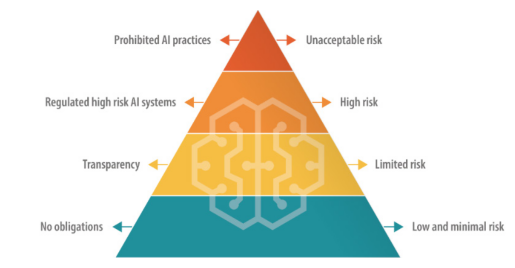

### Explanation:

The pyramid of risks is a diagram illustrating a risk-based approach to AI regulation. It is divided into four levels, each representing a different category of risk associated with AI systems:

1. Top Level (Red): Labeled "Prohibited AI practices," representing "Unacceptable risk." This level includes AI practices that are banned due to their potential threat to safety, livelihoods, and rights.

2. Second Level (Orange): Labeled "Regulated high risk AI systems," representing "High risk." This level includes AI systems that require strict regulation due to their significant risk.

3. Third Level (Yellow): Labeled "Transparency," representing "Limited risk." This level includes AI systems that require transparency measures but pose a lower risk.

4. Bottom Level (Blue): Labeled "No obligations," representing "Low and minimal risk." This level includes AI systems with minimal regulatory requirements due to their low risk.

The pyramid visually communicates the increasing level of regulatory intervention needed as the risk level of AI systems increases.

In [ ]:
# Example usage
multimodal_query(AIAct_index, "Explain pyramid of risks")

In [ ]:
def multimodal_query_with_speech(index, query, language="English"):
    """
    Queries both text and image data from the index, converts the response to speech, and returns image paths if available.

    Args:
        index: The multimodal index to query.
        query (str): The query or question to retrieve information from the index.
        language (str): Language for the text-to-speech output (default is "English").

    Returns:
        dict: A dictionary with 'text_response' from the multimodal query, 'audio_url' for the TTS output, and 'image_paths' if available.
    """
    # Step 1: Perform the multimodal query
    qa_template_str = """
    Context information is below.
    ---------------------
    {context_str}
    ---------------------
    Given the context information and no prior knowledge, answer the query:
    Query: {query_str}
    Answer:
    """
    qa_template = PromptTemplate(qa_template_str)

    # Initialize multimodal LLM and query engine
    openai_mm_llm = OpenAIMultiModal(model="gpt-4-vision-preview", api_key="your_openai_api_key")
    query_engine = index.as_query_engine(multi_modal_llm=openai_mm_llm, text_qa_template=qa_template)

    # Execute the query and get the response text
    response = query_engine.query(query)
    text_response = response.response

    # Collect image paths
    image_paths = []
    for source_node in response.source_nodes:
        if source_node.metadata.get("type") == "image":
            image_path = source_node.metadata.get("path")
            if image_path and os.path.exists(image_path):
                image_paths.append(image_path)

    # Step 2: Convert the text response to speech
    audio_url = None  # Default to None if there's an issue with TTS
    try:
        output = replicate_client.run(
            "cjwbw/seamless_communication:668a4fec05a887143e5fe8d45df25ec4c794dd43169b9a11562309b2d45873b0",
            input={
                "task_name": "T2ST (Text to Speech translation)",
                "input_text": text_response,
                "input_text_language": language,
                "target_language_with_speech": language,
                "max_input_audio_length": 60
            }
        )
        # Check if output is a URL string or FileOutput object and handle accordingly
        if isinstance(output["audio_output"], str):  # Direct URL
            audio_url = output["audio_output"]
        elif hasattr(output["audio_output"], 'read'):  # File-like object
            # Save locally if it’s a file-like object
            audio_file_path = "/content/drive/MyDrive/MultiModalRAG_Workshop/audio_response.wav"
            with open(audio_file_path, "wb") as f:
                f.write(output["audio_output"].read())
            audio_url = audio_file_path  # Use the saved file path as the URL
    except replicate.exceptions.ReplicateError as e:
        print("An error occurred during text-to-speech generation:", e)

    # Return the result
    return {
        "text_response": text_response,
        "audio_url": audio_url,
        "image_paths": image_paths  # List of paths for multiple images if available
    }


In [ ]:
from crewai import Crew, Process, Agent, Task
from crewai.tasks.conditional_task import ConditionalTask
from crewai_tools import tool
llm = "gpt-4o"
## Router Tool
@tool("router tool")
def router_tool(question: str) -> str:
    """Router function to determine if the task is indexing or querying."""
    prompt = f"""Based on the question provided below, determine the task type:

    1. If the question is about indexing a document, answer 'index'.
    2. If the question is related to querying an existing index (e.g., asking for explanations or details from indexed content), answer 'query'.

    Question: {question}

    RESPONSE INSTRUCTIONS:
    - Answer should strictly be either 'index' or 'query'.
    - Do not provide any preamble or additional explanations, only answer with 'index' or 'query'.

    OUTPUT FORMAT:
    index
    """
    response = llm.invoke(prompt).content.strip()
    return response

In [ ]:
@tool("retriever tool")
def retriever_tool(router_response: str, question: str, file_path: str = "", index: str = "") -> dict:
    """Retriever function to execute either indexing or querying based on router's response."""
    if router_response == 'index' and file_path:
        # Calls the indexing function to process the document
        return index_pdf(file_path)
    elif router_response == 'query' and index:
        # Calls the helper function for multimodal query with speech
        if isinstance(index, str):
            # Load the index by name if it's provided as a string (assuming a load function is available)
            index = load_index_by_name(index)  # Define this function based on your storage context
        result = multimodal_query_with_speech(index, question)
        return {
            "text_response": result["text_response"],
            "audio_url": result["audio_url"],
            "image_paths": result["image_paths"] if result["image_paths"] else []
        }
    else:
        return {"error": "Invalid input or missing data."}


In [ ]:

Router_Agent = Agent(
    role='Router',
    goal='Route user question to either document indexing or querying tasks based on context.',
    backstory=(
        "You are an expert in routing user questions between document indexing and querying tasks."
        "Analyze the user's question to decide whether it requires document indexing or querying an existing index."
        "If the question requests indexing, route it to the indexing process."
        "If the question is related to querying a provided index,"
        "Use context clues in the question to make this distinction clearly and efficiently."
    ),
    verbose=True,
    allow_delegation=False,
    llm=llm,
    tools=[router_tool],
)

In [ ]:
Retriever_Agent = Agent(
    role="Retriever",
    goal="Direct tasks to either document indexing or querying based on the Router's output.",
    backstory=(
        "You are responsible for executing either document indexing or querying tasks based on the Router's decision."
        "If the Router output indicates 'index,' you should proceed to index the provided document."
        "If the Router output indicates 'query,' retrieve relevant information from the provided index in the input to answer the user's question."
        "Ensure that each task is completed as specified without any additional actions or explanations."
    ),
    verbose=True,
    allow_delegation=False,
    llm=llm,
    tools=[retriever_tool],
)

In [ ]:
router_task = Task(
    description=(
        "Analyze the keywords in the question '{question}' to determine if it is a request for document indexing or querying."
        "If the question '{question}' asks for indexing a document, then route it to the indexing task, processing the document at the specified file path '{file_path}'."
        "If the question is about querying a provided index, then route it to the querying process and retrieve relevant details."
        "Return 'index' if the task is for indexing and 'query' if the task is for querying based on the analysis of the keywords."
        "Do not provide any additional explanations."
    ),
    expected_output=(
        "Return either 'index' or 'query' based on the analysis of the question '{question}' and available context."
        "Do not provide any preamble or explanations except the output of 'index' or 'query'."
    ),
    agent=Router_Agent,
)

retriever_task = Task(
    description=(
        "Based on the output from the 'router_task', perform the respective action for the question '{question}'."
        "If the 'router_task' output is 'index', proceed to index the document located at the provided file path '{file_path}'."
        "If the output is 'query', retrieve relevant information from the provided index using the question context '{question}' and provided '{index}'."
    ),
    expected_output=(
        "If the 'router_task' output is 'index', use the indexing tool to index the document at '{file_path}'."
        "If the output is 'query', use the querying tool to retrieve relevant information from the indexed content based on '{question}' and provided '{index}' and provide the 'text_response', 'audio_url', and 'image_path'."
    ),
    agent=Retriever_Agent,
    context=[router_task],
)


In [ ]:


crew = Crew(
    agents=[Router_Agent,Retriever_Agent],
    tasks=[router_task,retriever_task],
    verbose=True,
)

In [ ]:
# Example Inputs and Execution
inputs_index = {"question": "index document", "file_path": "AIAct.pdf", "index": ""}
result_index = crew.kickoff(inputs=inputs_index)

# Agent: Router
## Task: Analyze the keywords in the question 'index document' to determine if it is a request for document indexing or querying.If the question 'index document' asks for indexing a document, then route it to the indexing task, processing the document at the specified file path 'AIAct.pdf'.If the question is about querying a provided index, then route it to the querying process and retrieve relevant details.Return 'index' if the task is for indexing and 'query' if the task is for querying based on the analysis of the keywords.Do not provide any additional explanations.
 

I encountered an error while trying to use the tool. This was the error: 'str' object has no attribute 'invoke'.
 Tool router tool accepts these inputs: router tool(question: 'string') - Router function to determine if the task is indexing or querying. 



# Agent: Router
## Using tool: router tool
## Tool Input: 
"{\"question\": \"index document\"}"
## Tool Output: 

I encountered an error while tryin

In [ ]:

inputs_query = {"question": "Explain pyramid of risks", "file_path": "", "index": "AIAct_index"}
result_query = crew.kickoff(inputs=inputs_query)

# Agent: Router
## Task: Analyze the keywords in the question 'Explain pyramid of risks' to determine if it is a request for document indexing or querying.If the question 'Explain pyramid of risks' asks for indexing a document, then route it to the indexing task, processing the document at the specified file path ''.If the question is about querying a provided index, then route it to the querying process and retrieve relevant details.Return 'index' if the task is for indexing and 'query' if the task is for querying based on the analysis of the keywords.Do not provide any additional explanations.
 

I encountered an error while trying to use the tool. This was the error: 'str' object has no attribute 'invoke'.
 Tool router tool accepts these inputs: router tool(question: 'string') - Router function to determine if the task is indexing or querying. 



# Agent: Router
## Using tool: router tool
## Tool Input: 
"{\"question\": \"Explain pyramid of risks\"}"
## Tool Output: 

I encountered

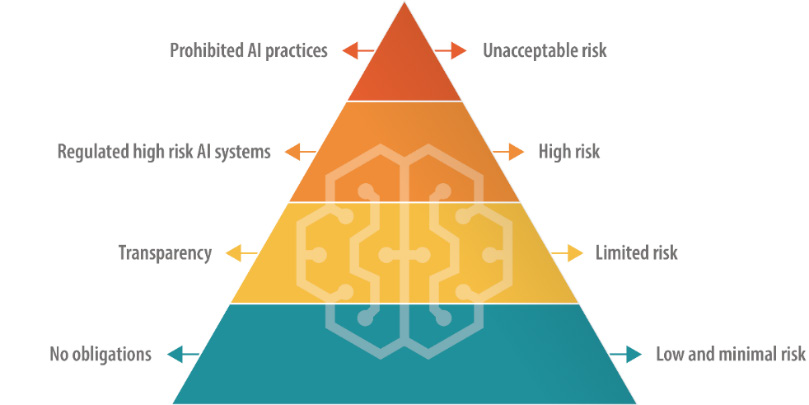

### Explanation:

The pyramid of risks is a diagram that illustrates a risk-based approach to AI regulation. It categorizes AI systems into four levels of risk:

1. **Unacceptable Risk (Top of the Pyramid)**: This section represents AI systems that pose a clear threat to safety, livelihoods, and rights, and are therefore banned.

2. **High Risk**: This section includes AI systems that require strict regulation due to their potential impact.

3. **Limited Risk**: This section covers AI systems that require some level of transparency but pose less risk.

4. **Low and Minimal Risk (Bottom of the Pyramid)**: This section represents AI systems that pose minimal risk and require no specific regulatory obligations.

The pyramid visually communicates the increasing level of regulatory intervention required as the risk level of AI systems increases.

In [ ]:
import re
from IPython.display import display, Markdown, Audio, Image

response = result_query.raw

# Extract image paths, explanation text, and audio URL
image_paths = response.get('image_paths', [])
text_response = response.get('text_response', '')
audio_url = response.get('audio_url', '')

# Display images
for image_path in set(image_paths):  # Use set to avoid duplicates
    display(Image(filename=image_path))

# Display explanation in Markdown
display(Markdown(f"### Explanation:\n\n{text_response}"))

# Play the audio file if URL is provided
if audio_url:
    display(Audio(filename=audio_url, autoplay=True))
